In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://washingtondc.craigslist.org/search/moa#search=1~gallery~0~20'
raw = requests.get(url,headers=header) # Get page

In [16]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

In [21]:
import re  # Regular expressions

brands = ['apple', 'samsung', 'huawei', 'xiaomi', 'oppo', 'vivo', 'nokia', 'google', 'oneplus', 'motorola',
          'sony', 'lg', 'zte', 'realme', 'asus', 'lenovo', 'meizu', 'blackberry', 'htc', 'alcatel',
          'micromax', 'infinix', 'itel', 'tecno', 'iphone']

data = []  # We'll save our listings in this object
for k in range(len(listings)):
    title = listings[k].find('div', class_='title').get_text().lower()
    price = listings[k].find('div', class_='price').get_text()
    link = listings[k].find(href=True)['href']

    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands]  # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]

    # Extract location from the listing (update this based on actual HTML structure for location)
    location_div = listings[k].find('div', class_='location')  # Adjust the class name based on website
    if location_div is not None:
        location = location_div.get_text().strip()
    else:
        location = 'missing'  # If location not found, set it to 'missing'

    # Append data to list
    data.append({'title': title, 'price': price, 'location': location, 'link': link, 'brand': brand})


In [22]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['location'] = [entry.get('location', 'Unknown') for entry in data]
print(df.shape)
df.to_csv('craigslist_cville_phones.csv') # Save data in case of a disaster
df.head()

(280, 5)


,title,price,location,link,brand
0,iphone case bundle,6,Vienna,https://washingtondc.craigslist.org/nva/mob/d/...,iphone
1,apple iphone 12 pro max 128gb unlocked - excel...,455,Fairfax,https://washingtondc.craigslist.org/nva/mob/d/...,apple
2,selfie lamp with phone holder,5,Haymarket,https://washingtondc.craigslist.org/nva/mob/d/...,missing
3,(new) google pixel 9 pro 128gb factory unlocke...,740,Arlington,https://washingtondc.craigslist.org/nva/mob/d/...,google
4,"unlocked samsung galaxy a03s 6.5"" octa-core 32...",80,"Fairfax, VA",https://washingtondc.craigslist.org/nva/mob/d/...,samsung


count       7.000000
mean      484.714286
std       531.656755
min         0.000000
25%        42.500000
50%       308.000000
75%       900.000000
max      1200.000000
Name: price, dtype: float64


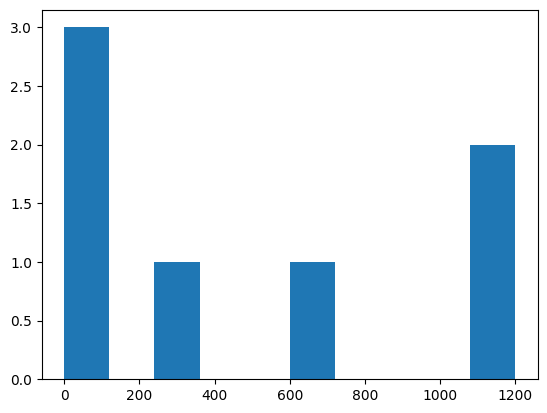

In [9]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()

In [10]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                             
        count    mean        std     min      25%     50%      75%     max
brand                                                                     
apple     1.0   308.0        NaN   308.0   308.00   308.0   308.00   308.0
iphone    2.0  1200.0    0.00000  1200.0  1200.00  1200.0  1200.00  1200.0
missing   1.0    10.0        NaN    10.0    10.00    10.0    10.00    10.0
nokia     1.0     0.0        NaN     0.0     0.00     0.0     0.00     0.0
samsung   2.0   337.5  371.23106    75.0   206.25   337.5   468.75   600.0

In [23]:
# Location by brand:
df.loc[:, ['location', 'brand']].groupby('brand').describe()

location                               
              count unique                top freq
brand                                             
apple            32     24      Tysons Corner    3
blackberry        1      1        West Mclean    1
google           10      9            Fairfax    2
iphone          114     55  northern virginia   17
lg                2      2             Vienna    1
missing          75     46          Arlington    7
motorola          3      3       Falls Church    1
nokia             2      2       Capitol Hill    1
oneplus           1      1          Chantilly    1
samsung          39     25        Fairfax, VA    6
xiaomi            1      1          Arlington    1

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 127803 (\N{SUNFLOWER}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127803 (\N{SUNFLOWER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


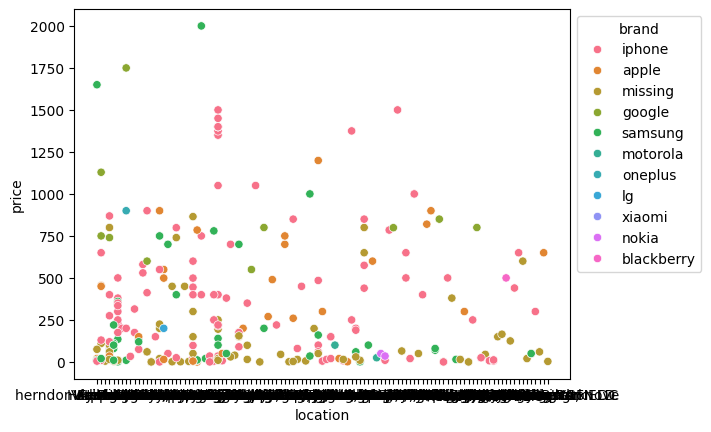

In [24]:
ax = sns.scatterplot(data=df, x='location', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))